# Module 05: RNN Fundamentals

**Understanding Recurrent Neural Networks and Their Limitations**

---

## 1. Objectives

- ✅ Understand why sequences need special treatment
- ✅ Master vanilla RNN architecture and equations
- ✅ Implement RNN from scratch
- ✅ Understand BPTT and vanishing gradients
- ✅ Use PyTorch nn.RNN

## 2. Prerequisites

- [Module 04: PyTorch Embeddings](../04_pytorch_embeddings/04_pytorch_embeddings.ipynb)
- Basic backpropagation knowledge

## 3. Intuition & Motivation

### Why Sequences Need Special Treatment

**Problem with feedforward networks:**
- Fixed input size
- No notion of order
- Can't handle "The cat sat" vs "sat cat The"

**What RNNs provide:**
- Variable length inputs
- Order matters
- "Memory" through hidden state

### The Core Idea

```
Process sequence one step at a time, maintaining a "memory" (hidden state)

x₁ → [RNN] → h₁
              ↓
x₂ → [RNN] → h₂
              ↓
x₃ → [RNN] → h₃ → output
```

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print("Setup complete!")

Setup complete!


## 4. Mathematical Foundation

### Vanilla RNN Equations

At each time step $t$:

$$h_t = \tanh(W_{hh} \cdot h_{t-1} + W_{xh} \cdot x_t + b_h)$$

$$y_t = W_{hy} \cdot h_t + b_y$$

Where:
- $x_t$ : Input at time $t$ — shape: `(input_size,)`
- $h_t$ : Hidden state at time $t$ — shape: `(hidden_size,)`
- $y_t$ : Output at time $t$ — shape: `(output_size,)`
- $W_{hh}$ : Hidden-to-hidden weights — shape: `(hidden_size, hidden_size)`
- $W_{xh}$ : Input-to-hidden weights — shape: `(hidden_size, input_size)`
- $W_{hy}$ : Hidden-to-output weights — shape: `(output_size, hidden_size)`

### Key Properties

- **Parameter sharing**: Same weights used at every time step
- **Hidden state**: Carries information across time steps
- **tanh**: Squashes values to [-1, 1]

## 5. RNN from Scratch

In [2]:
class VanillaRNN:
    """Vanilla RNN from scratch (NumPy)."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        self.hidden_size = hidden_size

        # Initialize weights (Xavier)
        scale = np.sqrt(2.0 / (input_size + hidden_size))
        self.W_xh = np.random.randn(hidden_size, input_size) * scale
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale
        self.W_hy = np.random.randn(output_size, hidden_size) * scale
        self.b_h = np.zeros((hidden_size, 1))
        self.b_y = np.zeros((output_size, 1))

    def forward(self, inputs, h_prev=None):
        """
        Forward pass through sequence.

        Args:
            inputs: List of input vectors, each shape (input_size, 1)
            h_prev: Initial hidden state, shape (hidden_size, 1)

        Returns:
            outputs: List of output vectors
            hidden_states: List of hidden states
        """
        if h_prev is None:
            h_prev = np.zeros((self.hidden_size, 1))

        outputs = []
        hidden_states = [h_prev]

        for x in inputs:
            # RNN step: h_t = tanh(W_xh @ x + W_hh @ h_{t-1} + b_h)
            h = np.tanh(
                self.W_xh @ x +
                self.W_hh @ h_prev +
                self.b_h
            )

            # Output: y_t = W_hy @ h_t + b_y
            y = self.W_hy @ h + self.b_y

            outputs.append(y)
            hidden_states.append(h)
            h_prev = h

        return outputs, hidden_states

# Test
rnn = VanillaRNN(input_size=10, hidden_size=20, output_size=5)
seq_len = 15
inputs = [np.random.randn(10, 1) for _ in range(seq_len)]

outputs, hiddens = rnn.forward(inputs)
print(f"Sequence length: {seq_len}")
print(f"Output shape per step: {outputs[0].shape}")
print(f"Hidden state shape: {hiddens[0].shape}")
print(f"Number of hidden states: {len(hiddens)} (includes initial)")

Sequence length: 15
Output shape per step: (5, 1)
Hidden state shape: (20, 1)
Number of hidden states: 16 (includes initial)


## 6. PyTorch Implementation

In [3]:
# PyTorch RNN
rnn_pt = nn.RNN(
    input_size=10,
    hidden_size=20,
    num_layers=1,
    batch_first=True,  # Input: (batch, seq, features)
    bidirectional=False
)

# Input: (batch_size, seq_len, input_size)
x = torch.randn(32, 15, 10)  # batch=32, seq=15, input=10

# Initial hidden: (num_layers, batch_size, hidden_size)
h0 = torch.zeros(1, 32, 20)

# Forward
output, h_n = rnn_pt(x, h0)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}  (all hidden states)")
print(f"h_n shape: {h_n.shape}  (final hidden state)")

Input shape: torch.Size([32, 15, 10])
Output shape: torch.Size([32, 15, 20])  (all hidden states)
h_n shape: torch.Size([1, 32, 20])  (final hidden state)


In [4]:
# Custom RNN Cell in PyTorch
class RNNCell(nn.Module):
    """Single RNN cell."""

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.W_xh = nn.Linear(input_size, hidden_size, bias=False)
        self.W_hh = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h_prev):
        """Single step: x (batch, input), h_prev (batch, hidden)"""
        return torch.tanh(self.W_xh(x) + self.W_hh(h_prev))

class MyRNN(nn.Module):
    """Full RNN using our cell."""

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = RNNCell(input_size, hidden_size)

    def forward(self, x, h0=None):
        """x: (batch, seq, input)"""
        batch_size, seq_len, _ = x.shape

        if h0 is None:
            h0 = torch.zeros(batch_size, self.hidden_size, device=x.device)

        outputs = []
        h = h0

        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(h)

        return torch.stack(outputs, dim=1), h

# Test
my_rnn = MyRNN(10, 20)
out, h_final = my_rnn(x)
print(f"My RNN output: {out.shape}")

My RNN output: torch.Size([32, 15, 20])


## 7. Backpropagation Through Time (BPTT)

### How Gradients Flow

```
Loss at t=3
    ↓
h₃ ← W_hh ← h₂ ← W_hh ← h₁ ← W_hh ← h₀
```

Gradient for $W_{hh}$ must be computed across ALL time steps.

### The Problem: Vanishing Gradients

For long sequences:

$$\frac{\partial L}{\partial h_0} = \frac{\partial L}{\partial h_T} \cdot \prod_{t=1}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Each term $\frac{\partial h_t}{\partial h_{t-1}} = W_{hh}^T \cdot \text{diag}(1 - h_t^2)$

If eigenvalues of $W_{hh} < 1$: gradients **vanish** exponentially
If eigenvalues of $W_{hh} > 1$: gradients **explode** exponentially

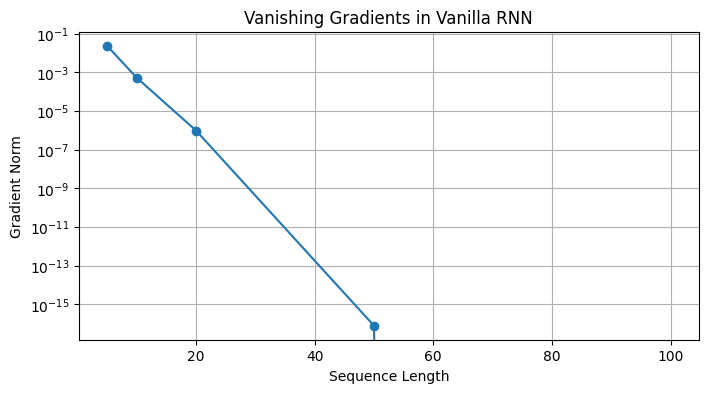

Notice: Gradients decrease exponentially with sequence length!


In [5]:
# Visualize gradient flow
def compute_gradient_norms(model, seq_lengths):
    """Compute gradient norms for different sequence lengths."""
    norms = []

    for seq_len in seq_lengths:
        model.zero_grad()
        x = torch.randn(1, seq_len, 10, requires_grad=True)
        h0 = torch.zeros(1, 1, 20, requires_grad=True)

        output, _ = model(x, h0)
        loss = output[:, -1, :].sum()  # Loss on last output
        loss.backward()

        # Gradient norm w.r.t first input
        grad_norm = x.grad[:, 0, :].norm().item()
        norms.append(grad_norm)

    return norms

seq_lengths = [5, 10, 20, 50, 100]
rnn_test = nn.RNN(10, 20, batch_first=True)
norms = compute_gradient_norms(rnn_test, seq_lengths)

plt.figure(figsize=(8, 4))
plt.plot(seq_lengths, norms, 'o-')
plt.xlabel('Sequence Length')
plt.ylabel('Gradient Norm')
plt.title('Vanishing Gradients in Vanilla RNN')
plt.yscale('log')
plt.grid(True)
plt.show()

print("Notice: Gradients decrease exponentially with sequence length!")

## 8. 🔥 Real-World Usage

### In 2024: Vanilla RNNs are NEVER used in practice!

**Why learn them?**
- Foundation for LSTM/GRU
- Understand sequence modeling concepts
- Interview questions

**What to use instead:**
| Task | Model |
|------|-------|
| Sequence modeling | LSTM, GRU |
| Classification | Transformers (BERT) |
| Generation | Transformers (GPT) |
| Streaming data | LSTM/GRU |

### Historical Importance
- 1986: BPTT introduced
- 1990s: Vanishing gradient problem identified
- 1997: LSTM invented to solve it

## 9. Common Mistakes

| Mistake | Fix |
|---------|-----|
| Forgetting to initialize h₀ | Use zeros or learnable |
| Wrong batch_first setting | Check tensor shapes |
| Using vanilla RNN for long sequences | Use LSTM/GRU |

## 10. Interview Questions

**Q1: Walk me through how an RNN processes a sequence**
<details><summary>Answer</summary>

1. Initialize hidden state h₀ (usually zeros)
2. For each input xₜ: compute hₜ = tanh(W_xh·xₜ + W_hh·hₜ₋₁ + b)
3. Same weights used at every step (parameter sharing)
4. Final hidden state contains summary of sequence
</details>

**Q2: Why do RNNs struggle with long sequences?**
<details><summary>Answer</summary>

Vanishing gradients: During BPTT, gradients are multiplied by W_hh repeatedly. If eigenvalues < 1, gradients shrink exponentially. Information from early inputs is lost.
</details>

**Q3: What is BPTT?**
<details><summary>Answer</summary>

Backpropagation Through Time: Unroll the RNN across time steps and apply standard backprop. Gradients flow backwards through all time steps.
</details>

## 11. Summary

- **RNN**: Process sequences with shared weights and hidden state
- **Equation**: $h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b)$
- **BPTT**: Backprop unrolled through time
- **Vanishing gradients**: Can't learn long dependencies
- **Practice**: Use LSTM/GRU instead

## 12. Exercises

1. Implement BPTT from scratch for the VanillaRNN class
2. Visualize hidden states over time for different sequences
3. Compare gradient norms: vanilla RNN vs LSTM
4. Train RNN on simple sequence prediction task

## 13. References

- [The Unreasonable Effectiveness of RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [PyTorch RNN Docs](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

---
**Next:** [Module 06: LSTM](../06_lstm/06_lstm.ipynb)